# Data mining Coursework - Energy Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats
from scipy.cluster import hierarchy
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


## Load Data!

In [2]:
df = pd.read_csv('C:\\Users\\sisma\\Desktop\\World Energy Data Set.csv')
df

Country                Energy_type  Year  Energy_consumption  \
0      Afghanistan           all_energy_types  1980            0.026583   
1      Afghanistan                       coal  1980            0.002479   
2      Afghanistan                natural_gas  1980            0.002094   
3      Afghanistan  petroleum_n_other_liquids  1980            0.014624   
4      Afghanistan                    nuclear  1980                 NaN   
...            ...                        ...   ...                 ...   
55435     Zimbabwe                       coal  2019            0.045064   
55436     Zimbabwe                natural_gas  2019            0.000000   
55437     Zimbabwe  petroleum_n_other_liquids  2019            0.055498   
55438     Zimbabwe                    nuclear  2019                 NaN   
55439     Zimbabwe         renewables_n_other  2019            0.068089   

       Energy_production      GDP  Population  Energy_intensity_per_capita  \
0               0.072561      NaN     13356.5                     1.990283   
1               0.002355      NaN     13356.5                     1.990283   
2               0.062820      NaN     13356.5                     1.990283   
3               0.000000      NaN     13356.5                     1.990283   
4                    NaN      NaN     13356.5                     1.990283   
...                  ...      ...         ...                          ...   
55435           0.075963  37.6204     14654.2                    11.508701   
55436           0.000000  37.6204     14654.2                    11.508701   
55437           0.000000  37.6204     14654.2                    11.508701   
55438                NaN  37.6204     14654.2                    11.508701   
55439           0.067499  37.6204     14654.2                    11.508701   

       Energy_intensity_by_GDP  CO2_emission  
0                     0.000000           NaN  
1                     0.000000           NaN  
2                     0.000000           NaN  
3                     0.000000           NaN  
4                     0.000000      0.000000  
...                        ...           ...  
55435                 4.482962      4.586869  
55436                 4.482962      0.000000  
55437                 4.482962      4.377890  
55438                 4.482962      0.000000  
55439                 4.482962      0.000000  

[55440 rows x 10 columns]

## Clean Data!

In [3]:
#Drop NaN values!
df = df.dropna().reset_index(drop=True)
# Detect for duplicates
duplicates = df[df.duplicated()]

# Print the number of duplicates
print(f"Number of duplicate rows: {len(duplicates)}")

# Display the duplicate rows
print("Duplicate rows:")
print(duplicates)
print(df[df['Energy_type'] == 'all_energy_types'].isnull().sum())

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [Country, Energy_type, Year, Energy_consumption, Energy_production, GDP, Population, Energy_intensity_per_capita, Energy_intensity_by_GDP, CO2_emission]
Index: []
Country                        0
Energy_type                    0
Year                           0
Energy_consumption             0
Energy_production              0
GDP                            0
Population                     0
Energy_intensity_per_capita    0
Energy_intensity_by_GDP        0
CO2_emission                   0
dtype: int64


## Detect Outliers!

In [4]:
# Data set
data = df[df['Energy_type'] == 'all_energy_types'].copy()

# Function to detect outliers using Z-score, grouped by country
def detect_outliers_zscore(df, column):
    grouped = df.groupby('Country')
    outliers = pd.DataFrame()
    
    for group_name, group_data in grouped:
        group_data = group_data.copy()
        group_data['zscore'] = stats.zscore(group_data[column], nan_policy='omit')

        group_outliers = group_data[(group_data['zscore'] < -4) | (group_data['zscore'] > 4)]
        outliers = pd.concat([outliers, group_outliers])
    
    return outliers

# Iterate through all numerical columns and find the outliers
for column in data.select_dtypes(include=['number']).columns:
    if column != 'Country':  # Ignore the 'Country' column
        outliers = detect_outliers_zscore(data, column)
        
        # Print the number of outliers for the current column
        print(f"Number of outliers in {column}: {len(outliers)}")
        
        # Show the outliers for the current column
        print(f"Outliers in {column}:")
        print(outliers)
        print("\n")

Number of outliers in Year: 0
Outliers in Year:
Empty DataFrame
Columns: [Country, Energy_type, Year, Energy_consumption, Energy_production, GDP, Population, Energy_intensity_per_capita, Energy_intensity_by_GDP, CO2_emission, zscore]
Index: []


Number of outliers in Energy_consumption: 0
Outliers in Energy_consumption:
Empty DataFrame
Columns: [Country, Energy_type, Year, Energy_consumption, Energy_production, GDP, Population, Energy_intensity_per_capita, Energy_intensity_by_GDP, CO2_emission, zscore]
Index: []


Number of outliers in Energy_production: 3
Outliers in Energy_production:
           Country       Energy_type  Year  Energy_consumption  \
13473    Hong Kong  all_energy_types  2014            1.169728   
19114   Mauritania  all_energy_types  2006            0.021662   
23905  Puerto Rico  all_energy_types  2019            0.295735   

       Energy_production       GDP  Population  Energy_intensity_per_capita  \
13473           0.004553  401.8279    7142.022                

## Feature Engineering (Continent column)

In [5]:
#create a new column Continent
continent_dict = {
    'Africa': ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Republic of the Congo', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'],
    'Asia': ['Afghanistan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'East Timor', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'],
    'Europe': ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican City'],
    'North America': ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States of America'],
    'South America': ['Argentina', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela (Bolivarian Republic of)'],
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia (Federated States of)', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu']

}

# create a dictionary mapping each country to its continent
country_to_continent = {}
for continent, countries in continent_dict.items():
    for country in countries:
        country_to_continent[country] = continent

# create the "Continent" column using the dictionary mapping
df['Continent'] = df['Country'].map(country_to_continent)
df.insert(1, 'Continent', df.pop('Continent'))
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# create the dictionary
continent_dict = {
    'American Samoa': 'Oceania',
    'Antarctica': 'Antarctica',
    'Aruba': 'North America',
    'Bermuda': 'North America',
    'Bolivia': 'South America',
    'British Virgin Islands': 'North America',
    'Burma': 'Asia',
    'Cabo Verde': 'Africa',
    'Cayman Islands': 'North America',
    'Congo-Brazzaville': 'Africa',
    'Congo-Kinshasa': 'Africa',
    'Cook Islands': 'Oceania',
    'Côte d’Ivoire': 'Africa',
    'Eswatini': 'Africa',
    'Falkland Islands': 'South America',
    'Faroe Islands': 'Europe',
    'Former Czechoslovakia': 'Europe',
    'Former Serbia and Montenegro': 'Europe',
    'Former U.S.S.R.': 'Asia',
    'Former Yugoslavia': 'Europe',
    'French Guiana': 'South America',
    'French Polynesia': 'Oceania',
    'Gambia, The': 'Africa',
    'Germany, East': 'Europe',
    'Germany, West': 'Europe',
    'Gibraltar': 'Europe',
    'Greenland': 'North America',
    'Guadeloupe': 'North America',
    'Guam': 'Oceania',
    'Hawaiian Trade Zone': 'Oceania',
    'Hong Kong': 'Asia',
    'Macau': 'Asia',
    'Martinique': 'North America',
    'Micronesia': 'Oceania',
    'Montserrat': 'North America',
    'Netherlands Antilles': 'North America',
    'New Caledonia': 'Oceania',
    'Niue': 'Oceania',
    'North Macedonia': 'Europe',
    'Northern Mariana Islands': 'Oceania',
    'Palestinian Territories': 'Asia',
    'Puerto Rico': 'North America',
    'Reunion': 'Africa',
    'Saint Helena': 'Africa',
    'Saint Pierre and Miquelon': 'North America',
    'Saint Vincent/Grenadines': 'North America',
    'The Bahamas': 'North America',
    'Timor-Leste': 'Asia',
    'Turks and Caicos Islands': 'North America',
    'U.S. Pacific Islands': 'Oceania',
    'U.S. Territories': 'North America',
    'U.S. Virgin Islands': 'North America',
    'United States': 'North America',
    'Venezuela': 'South America',
    'Wake Island': 'Oceania',
    'Western Sahara': 'Africa',
    'World': 'World'
}


# replace the values in the continent column with the dictionary values
df['Continent'] = df['Continent'].fillna(df['Country'].map(continent_dict))
countries_with_missing_continent = df.loc[df['Continent'].isna(), 'Country'].unique()
df.to_csv('df_new.csv', index=False)
print(countries_with_missing_continent)
df

[]


Country Continent                Energy_type  Year  \
0      Afghanistan      Asia           all_energy_types  1988   
1      Afghanistan      Asia                       coal  1988   
2      Afghanistan      Asia                natural_gas  1988   
3      Afghanistan      Asia  petroleum_n_other_liquids  1988   
4      Afghanistan      Asia         renewables_n_other  1988   
...            ...       ...                        ...   ...   
33300     Zimbabwe    Africa           all_energy_types  2019   
33301     Zimbabwe    Africa                       coal  2019   
33302     Zimbabwe    Africa                natural_gas  2019   
33303     Zimbabwe    Africa  petroleum_n_other_liquids  2019   
33304     Zimbabwe    Africa         renewables_n_other  2019   

       Energy_consumption  Energy_production      GDP  Population  \
0                0.111221           0.121394  37.7013     11618.0   
1                0.002875           0.002731  37.7013     11618.0   
2                0.073290           0.110982  37.7013     11618.0   
3                0.027375           0.000000  37.7013     11618.0   
4                0.007681           0.007681  37.7013     11618.0   
...                   ...                ...      ...         ...   
33300            0.168651           0.143462  37.6204     14654.2   
33301            0.045064           0.075963  37.6204     14654.2   
33302            0.000000           0.000000  37.6204     14654.2   
33303            0.055498           0.000000  37.6204     14654.2   
33304            0.068089           0.067499  37.6204     14654.2   

       Energy_intensity_per_capita  Energy_intensity_by_GDP  CO2_emission  
0                         9.573144                 2.950052      3.646724  
1                         9.573144                 2.950052      0.324617  
2                         9.573144                 2.950052      1.222107  
3                         9.573144                 2.950052      2.100000  
4                         9.573144                 2.950052      0.000000  
...                            ...                      ...           ...  
33300                    11.508701                 4.482962      8.964759  
33301                    11.508701                 4.482962      4.586869  
33302                    11.508701                 4.482962      0.000000  
33303                    11.508701                 4.482962      4.377890  
33304                    11.508701                 4.482962      0.000000  

[33305 rows x 11 columns]

## Exploratory Data Analysis (EDA) 

### 	A pairplot that provides a high-level overview and first-hand inspection of the relationships and distributions worldwide.

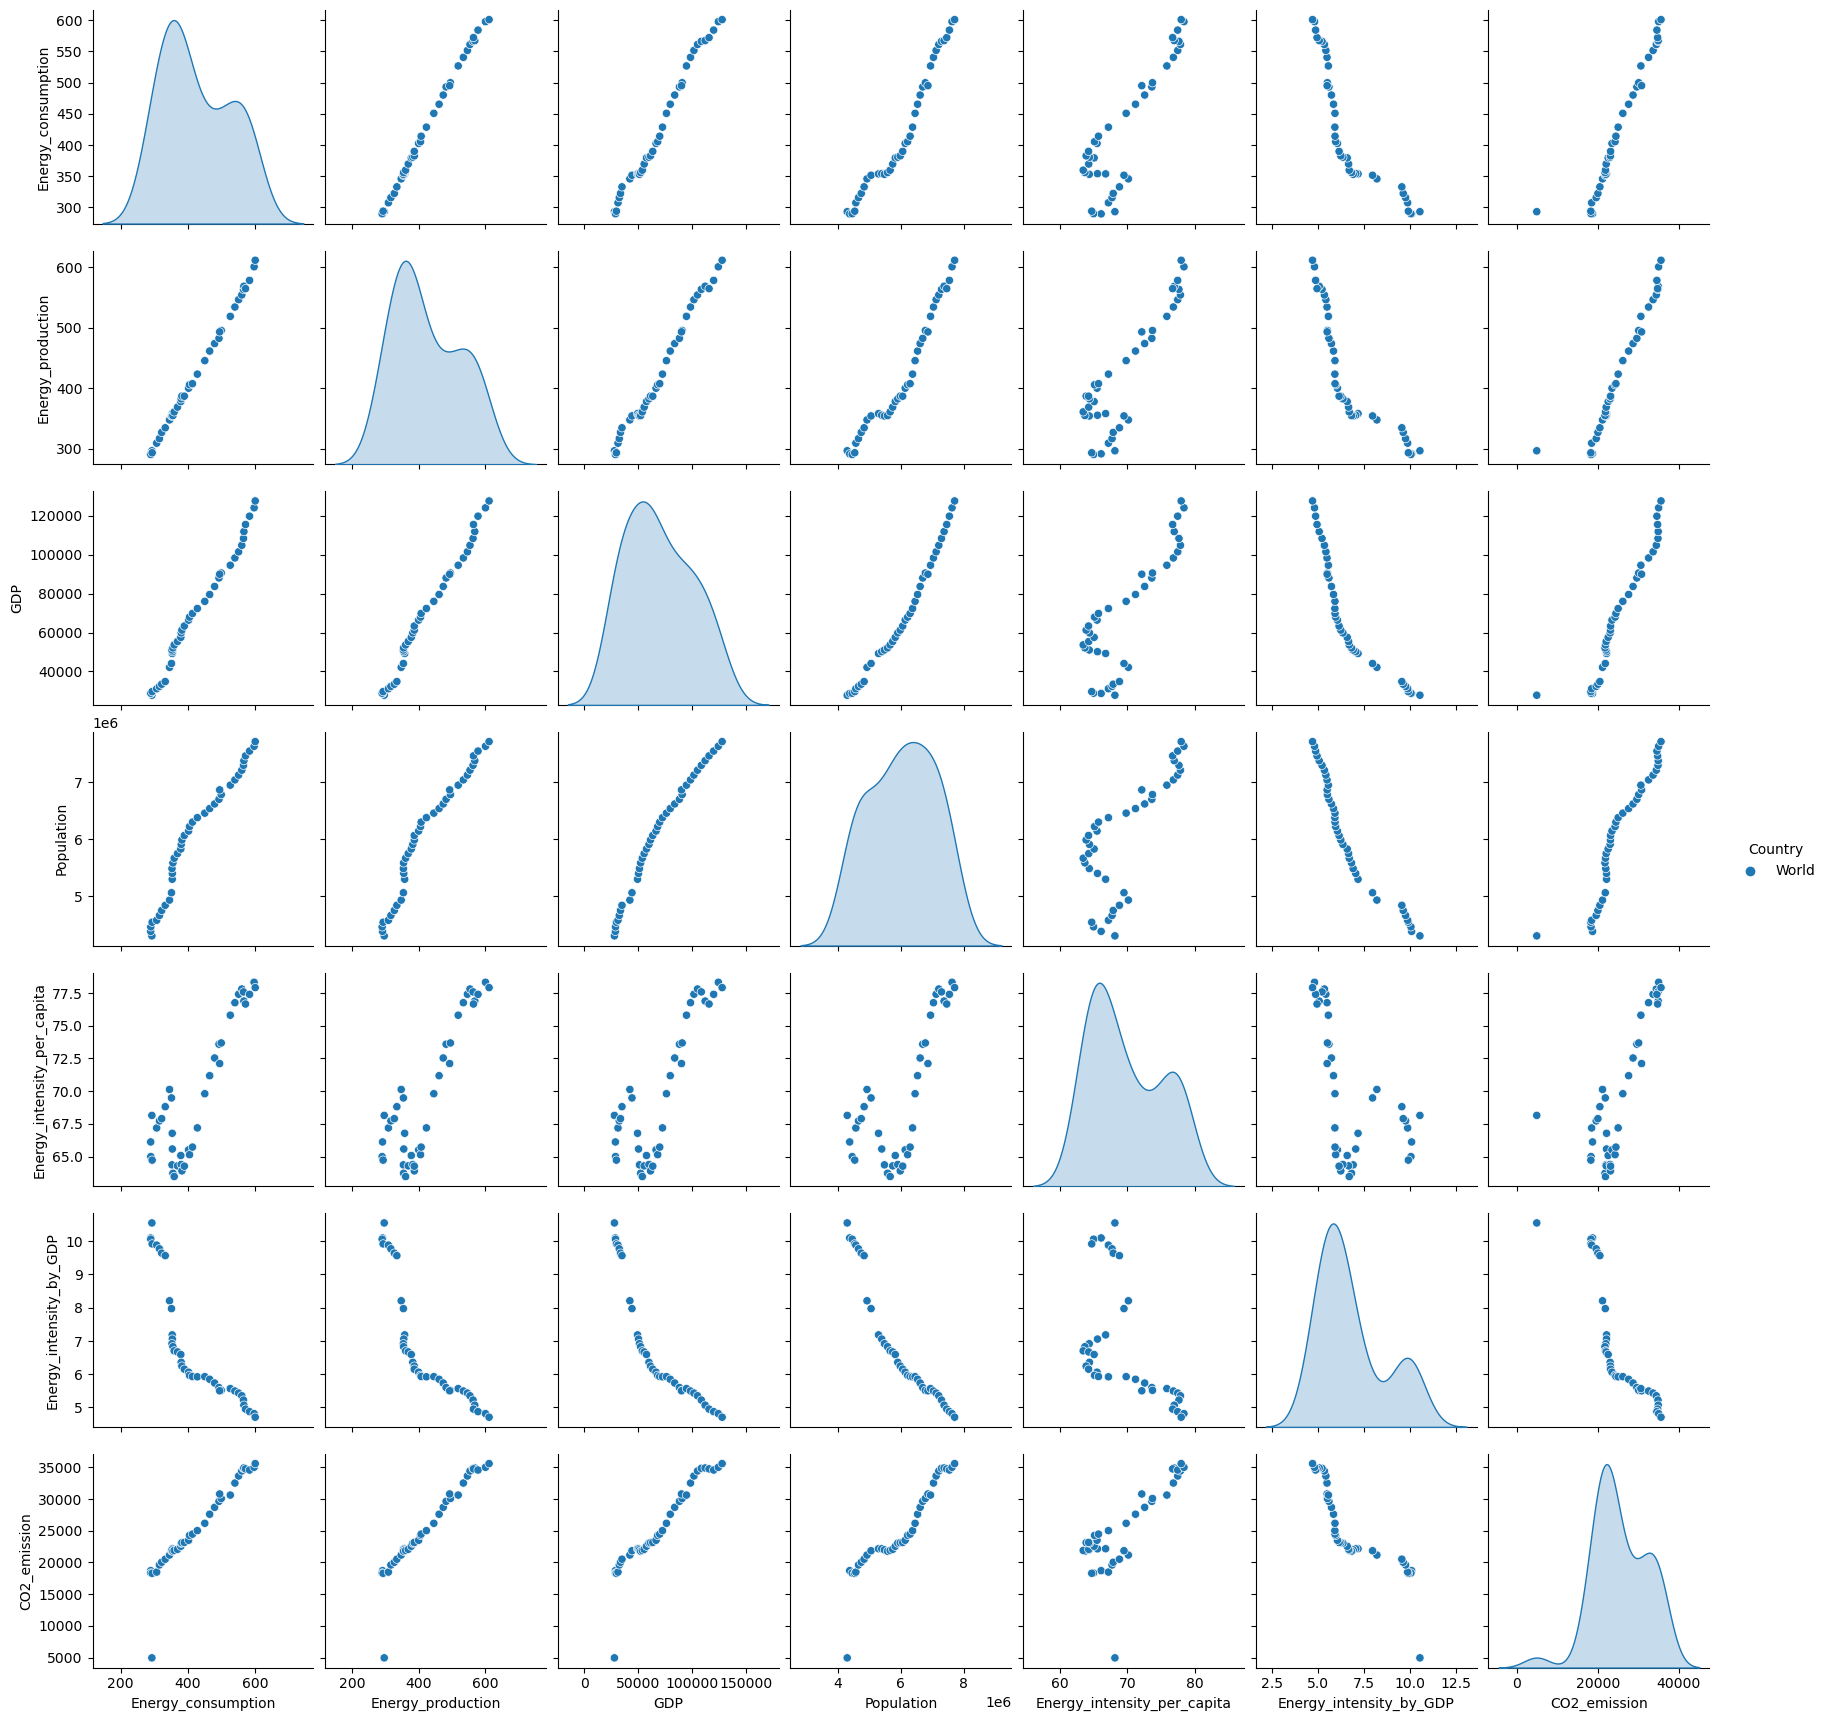

In [6]:
data = df[(df['Country'] == 'World') & (df['Energy_type'] == 'all_energy_types')].copy()
sns.pairplot(data, vars=['Energy_consumption', 'Energy_production', 'GDP', 'Population', 'Energy_intensity_per_capita', 'Energy_intensity_by_GDP', 'CO2_emission'], hue='Country')
plt.show()

### A line chart visualization that provides a clear view of the CO2 emissions trend for each continent over time. It helps to understand how the CO2 emissions have changed year-by-year on different continents.

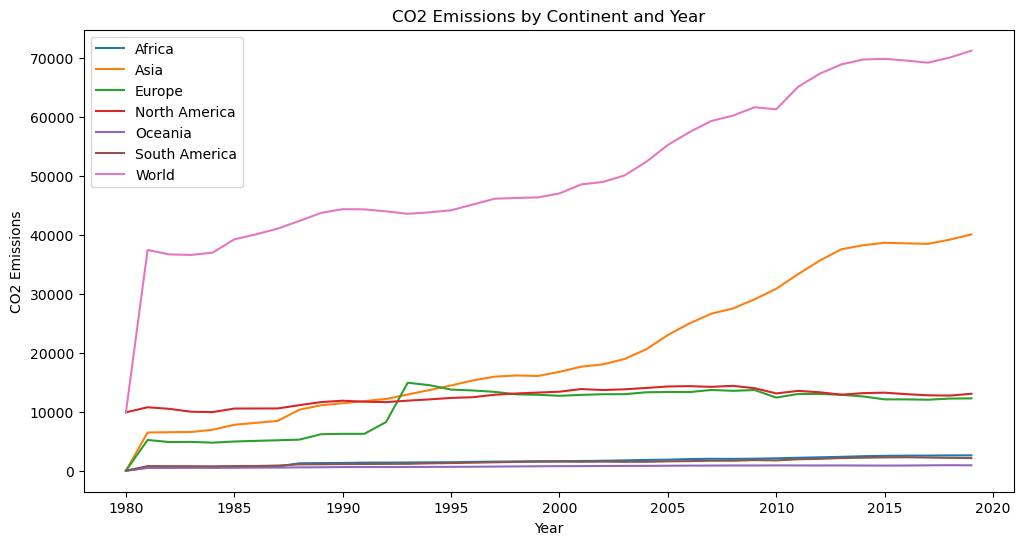

In [7]:
# Load dataset
data = df.copy()

# Group the data by 'Continent' and 'Year', then sum the CO2 emissions
grouped_data = data.groupby(['Continent', 'Year'])['CO2_emission'].sum().reset_index()

# Get the list of unique continents
continents = grouped_data['Continent'].unique()

# Create a line chart for each continent
fig, ax = plt.subplots(figsize=(12, 6))

for continent in continents:
    continent_data = grouped_data[grouped_data['Continent'] == continent]
    ax.plot(continent_data['Year'], continent_data['CO2_emission'], label=continent)

# Set the labels for the x-axis, y-axis, and the title
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Emissions')
ax.set_title('CO2 Emissions by Continent and Year')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

### A stacked bar plot showing the total CO2 emissions for each continent, grouped by different energy types.

In [8]:
# Load dataset
data = df[df['Continent']!= 'World'].copy()
# Group by 'Continent' and 'Energy_type', and aggregate the CO2 emissions
grouped_data = data.groupby(['Continent', 'Energy_type']).agg({'CO2_emission': 'sum'}).reset_index()

# Pivot the data to have energy types as columns
pivoted_data = grouped_data.pivot_table(values='CO2_emission', index='Continent', columns='Energy_type', fill_value=0)

# Create a stacked bar plot with aggregated CO2 emissions by 'Continent' and 'Energy_type'
fig = go.Figure()

for energy_type in pivoted_data.columns:
    fig.add_trace(go.Bar(
        x=pivoted_data.index,
        y=pivoted_data[energy_type],
        name=energy_type,
        
    ))

fig.update_layout(
    title='Total CO2 Emissions by Energy Type and Continent',
    xaxis_title='Continent',
    yaxis_title='Total CO2 Emissions',
    barmode='stack'
)

fig.show()

### A bar chart that displays the country with the maximum CO2 emissions for each energy type.

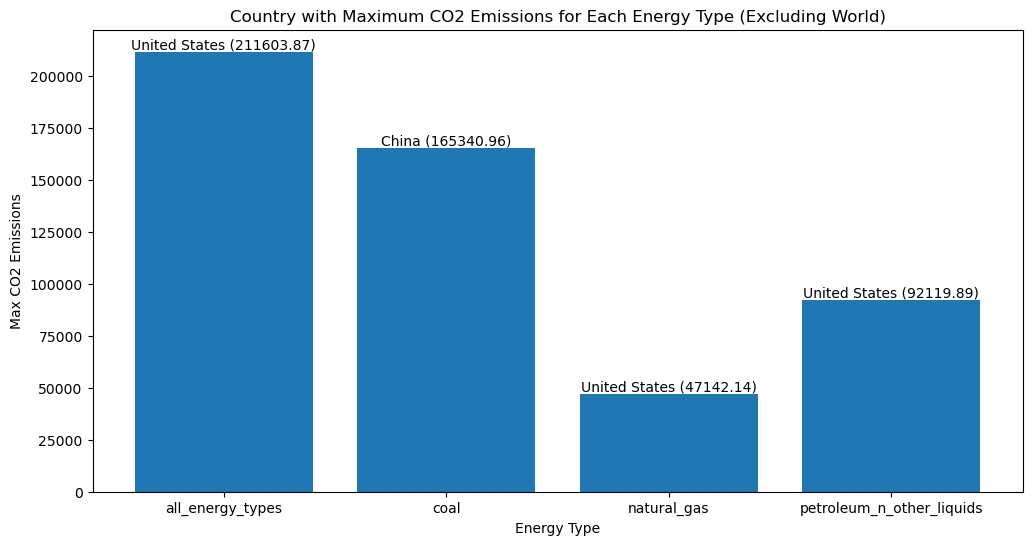

In [9]:
# Load dataset
data = df.copy()
energy_types = ['all_energy_types', 'coal', 'natural_gas', 'petroleum_n_other_liquids']
filtered_data = data[(data['Energy_type'].isin(energy_types)) & (data['Country'] != 'World')]

# Group the data by 'Energy_type' and 'Country', then sum the CO2 emissions
grouped_data = filtered_data.groupby(['Energy_type', 'Country'])['CO2_emission'].sum().reset_index()

# Find the country with the maximum CO2 emission in each group
result = grouped_data.loc[grouped_data.groupby('Energy_type')['CO2_emission'].idxmax()]

# Create a bar chart to visualize the results with a larger figure size
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(result['Energy_type'], result['CO2_emission'])

# Set the labels for the x-axis, y-axis, and the title
ax.set_xlabel('Energy Type')
ax.set_ylabel('Max CO2 Emissions')
ax.set_title('Country with Maximum CO2 Emissions for Each Energy Type (Excluding World)')

# Add country labels and CO2 emission values on top of each bar
for i, row in result.iterrows():
    ax.text(row['Energy_type'], row['CO2_emission'], f"{row['Country']} ({row['CO2_emission']:.2f})", ha='center', va='bottom')

# Show the plot
plt.show()


### A heatmap that provides a visual summary of the correlation structure among the numeric features in the DataFrame.

Text(0.5, 1.0, 'Correlation Metric For Numeric Features')

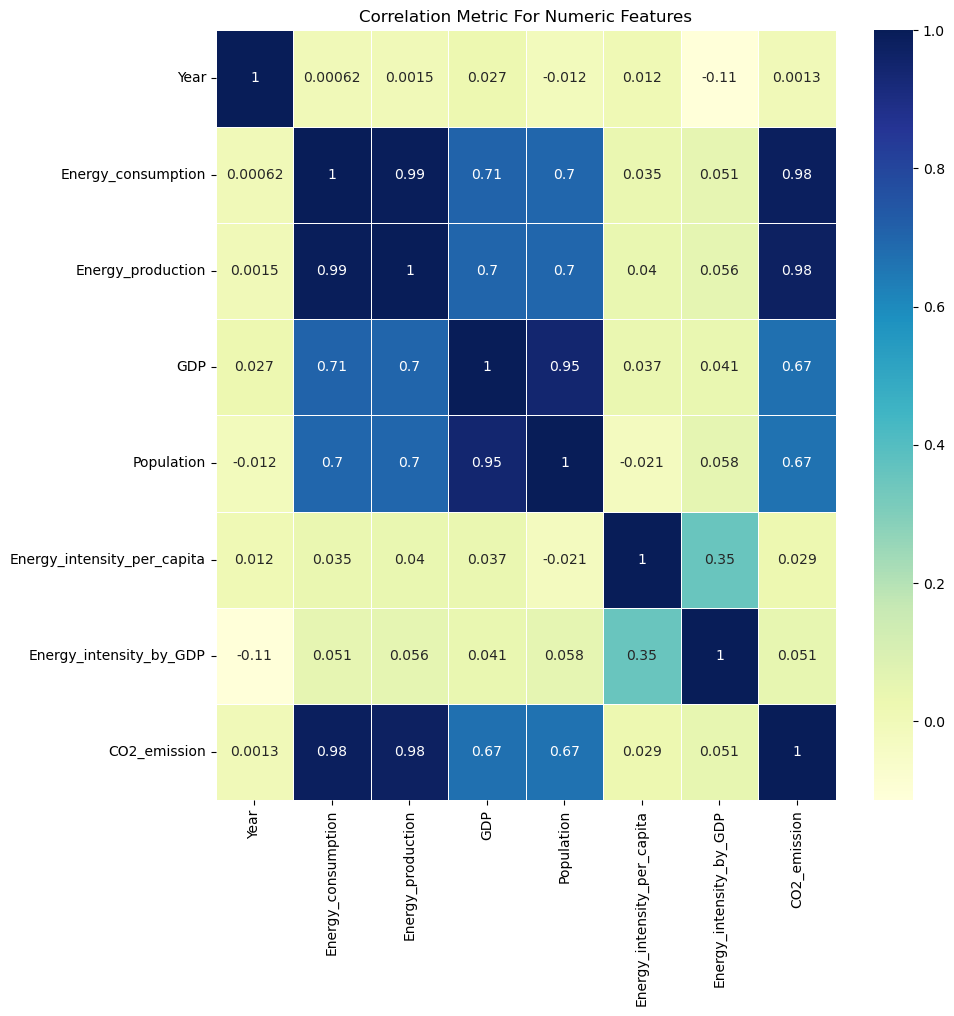

In [10]:
correlation_matrix = df.corr(method='pearson')
fig, ax = plt.subplots(figsize =(10,10))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot = True, linewidths=.5, ax = ax)
plt.title("Correlation Metric For Numeric Features")


## Random Forest Regression Analysis - Importance of each feature in CO2 emissions. 

In [11]:
# Load dataset
data = df.copy()

# Select the relevant columns
features = ['Population', 'Energy_production', 'Energy_consumption', 'GDP']
target = 'CO2_emission'
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Print the importance of each feature
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance}')


Population: 0.011228948034079691
Energy_production: 0.4150456065194012
Energy_consumption: 0.5617189144397189
GDP: 0.012006531006800276


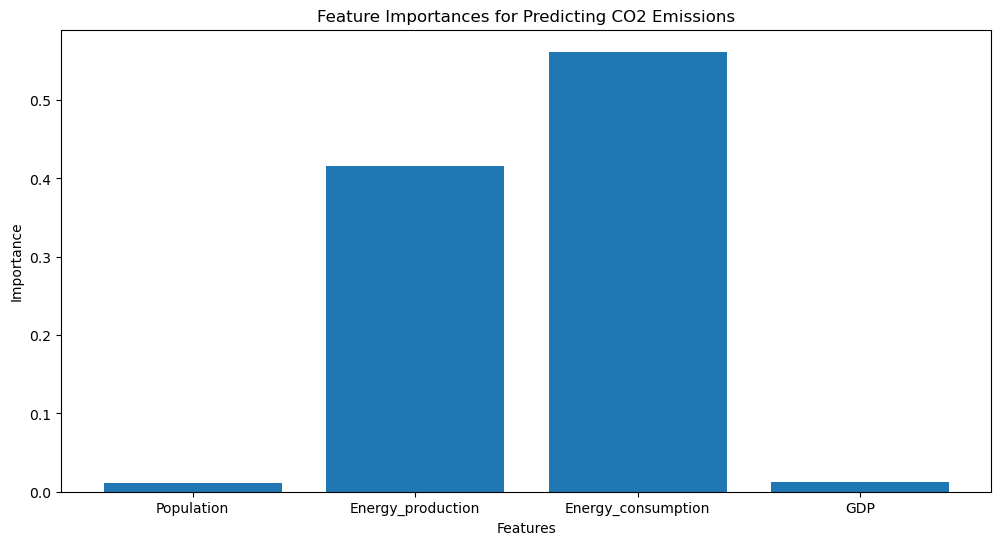

In [12]:
# Create a bar chart of feature importances
plt.figure(figsize=(12, 6))
plt.bar(features, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances for Predicting CO2 Emissions')
plt.show()

## Decision Tree Classifier -  Prediction CO2 emission categories.

Accuracy: 0.9551148225469729
Classification report:
               precision    recall  f1-score   support

        high       0.98      0.98      0.98      1520
         low       0.90      0.96      0.93       255
      medium       0.77      0.67      0.72       141

    accuracy                           0.96      1916
   macro avg       0.88      0.87      0.88      1916
weighted avg       0.95      0.96      0.95      1916



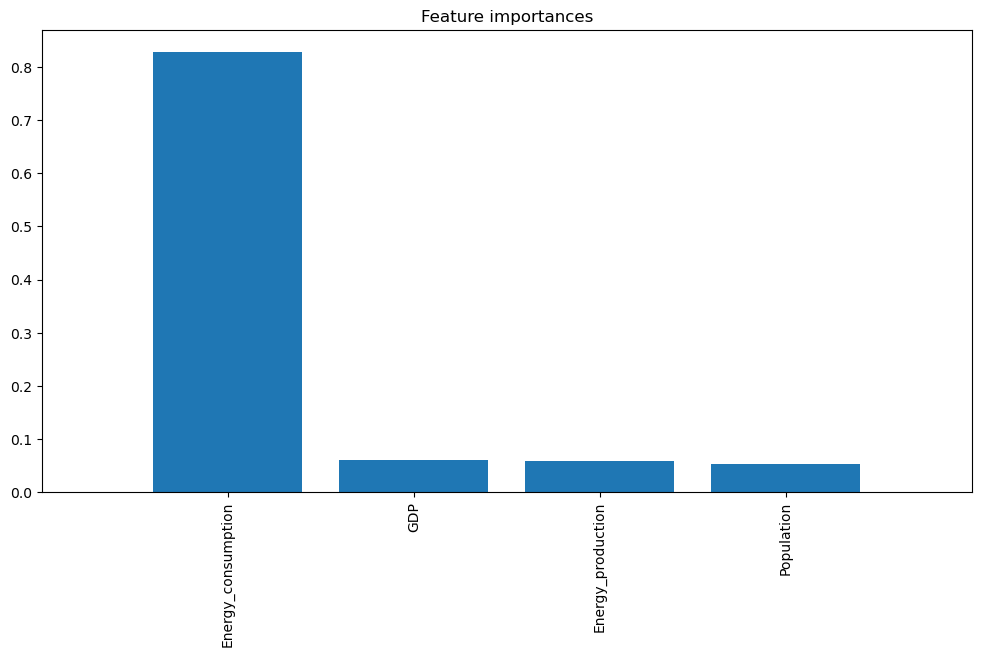

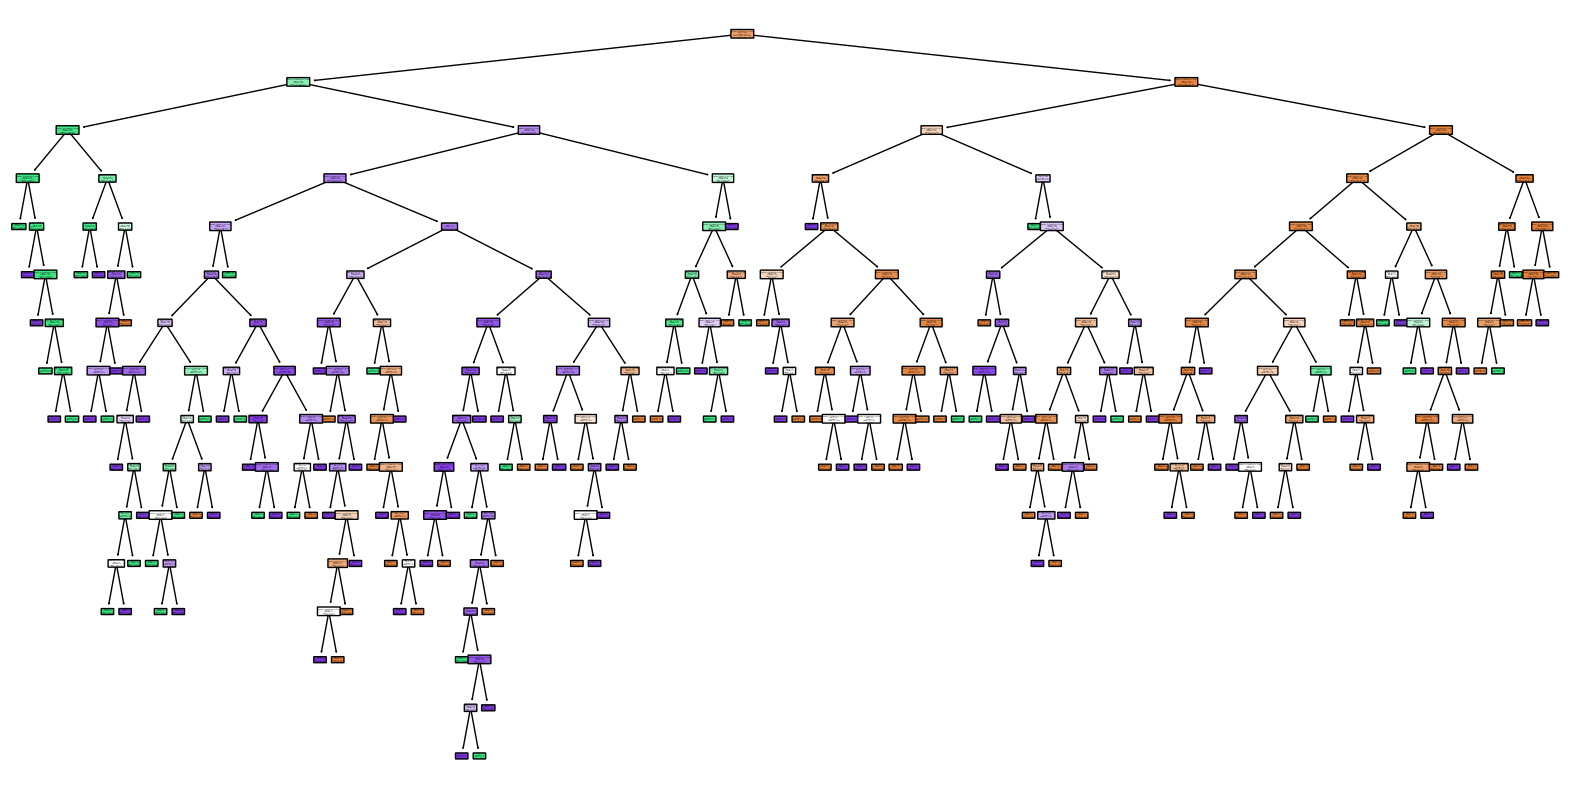

In [13]:
# Read the dataset

data = df.copy()
# Filter the dataset to include only the desired energy types
energy_types = ['all_energy_types']
filtered_data = data[(data['Energy_type'].isin(energy_types))& (data['Country']!='World')]

# Drop rows with missing values
filtered_data = filtered_data.dropna()

# Discretize the CO2_emission column into categorical bins (low, medium, high)
filtered_data['CO2_emission_category'] = pd.cut(filtered_data['CO2_emission'], bins=[-1, 0.5, 1.0, float('inf')], labels=['low', 'medium', 'high'])

# Prepare the input and target variables
X = filtered_data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]
y = filtered_data['CO2_emission_category']


scaler = StandardScaler()
features = scaler.fit_transform(X)

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the CO2 emission categories using the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification report:\n", classification_report(y_test, y_pred))

# Plot feature importances
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['low', 'medium', 'high'], filled=True, rounded=True)
plt.show()


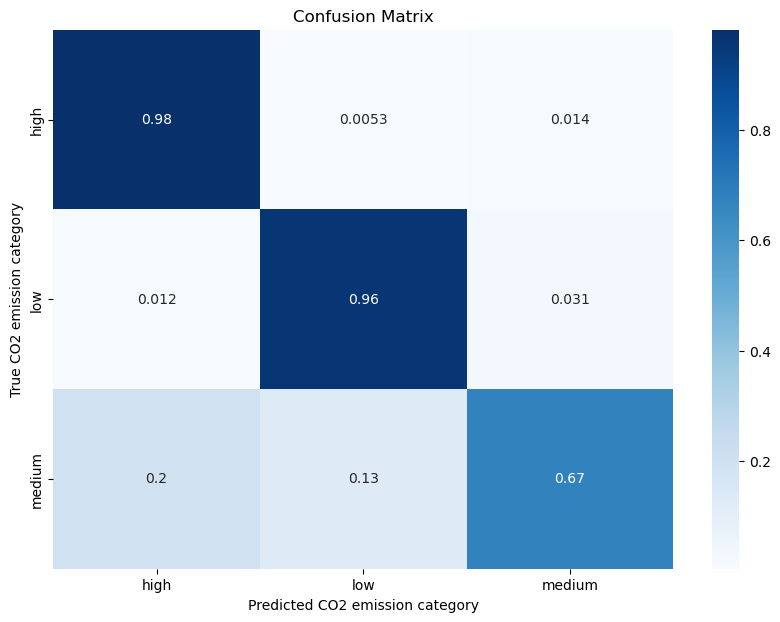

In [14]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['high', 'low', 'medium'], yticklabels=['high', 'low', 'medium'])
plt.xlabel('Predicted CO2 emission category')
plt.ylabel('True CO2 emission category')
plt.title('Confusion Matrix')
plt.show()


## Random Forest Classifier - Prediction CO2 emission categories.

              precision    recall  f1-score   support

        high       0.98      0.99      0.98       629
         low       0.99      0.96      0.97       651
      medium       0.94      0.97      0.96       636

    accuracy                           0.97      1916
   macro avg       0.97      0.97      0.97      1916
weighted avg       0.97      0.97      0.97      1916



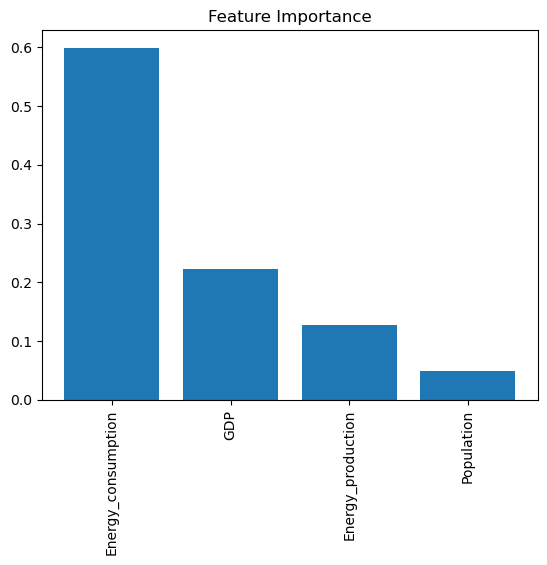

In [15]:
# We will use data from the 'all_energy_types' and exclude 'World' from country
data = df[(df['Energy_type'] == 'all_energy_types') & (df['Country'] != 'World')].copy()

# Create CO2 emission categories based on quantiles
data['CO2_emission_category'] = pd.qcut(data['CO2_emission'], q=3, labels=['low', 'medium', 'high'])

# Select features
features = data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]

# Select target
target = data['CO2_emission_category']

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict the classes for the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Fit the model
clf.fit(X_train, y_train)

# Get feature importance
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = ['Energy_consumption', 'Energy_production', 'GDP', 'Population']

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), [names[i] for i in indices], rotation=90)

# Show plot
plt.show()


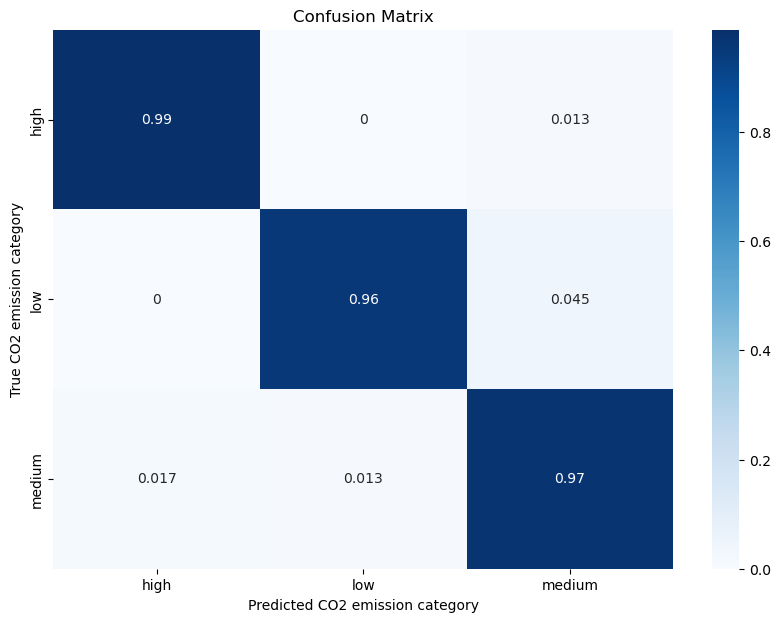

In [16]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['high', 'low', 'medium'], yticklabels=['high', 'low', 'medium'])
plt.xlabel('Predicted CO2 emission category')
plt.ylabel('True CO2 emission category')
plt.title('Confusion Matrix')
plt.show()

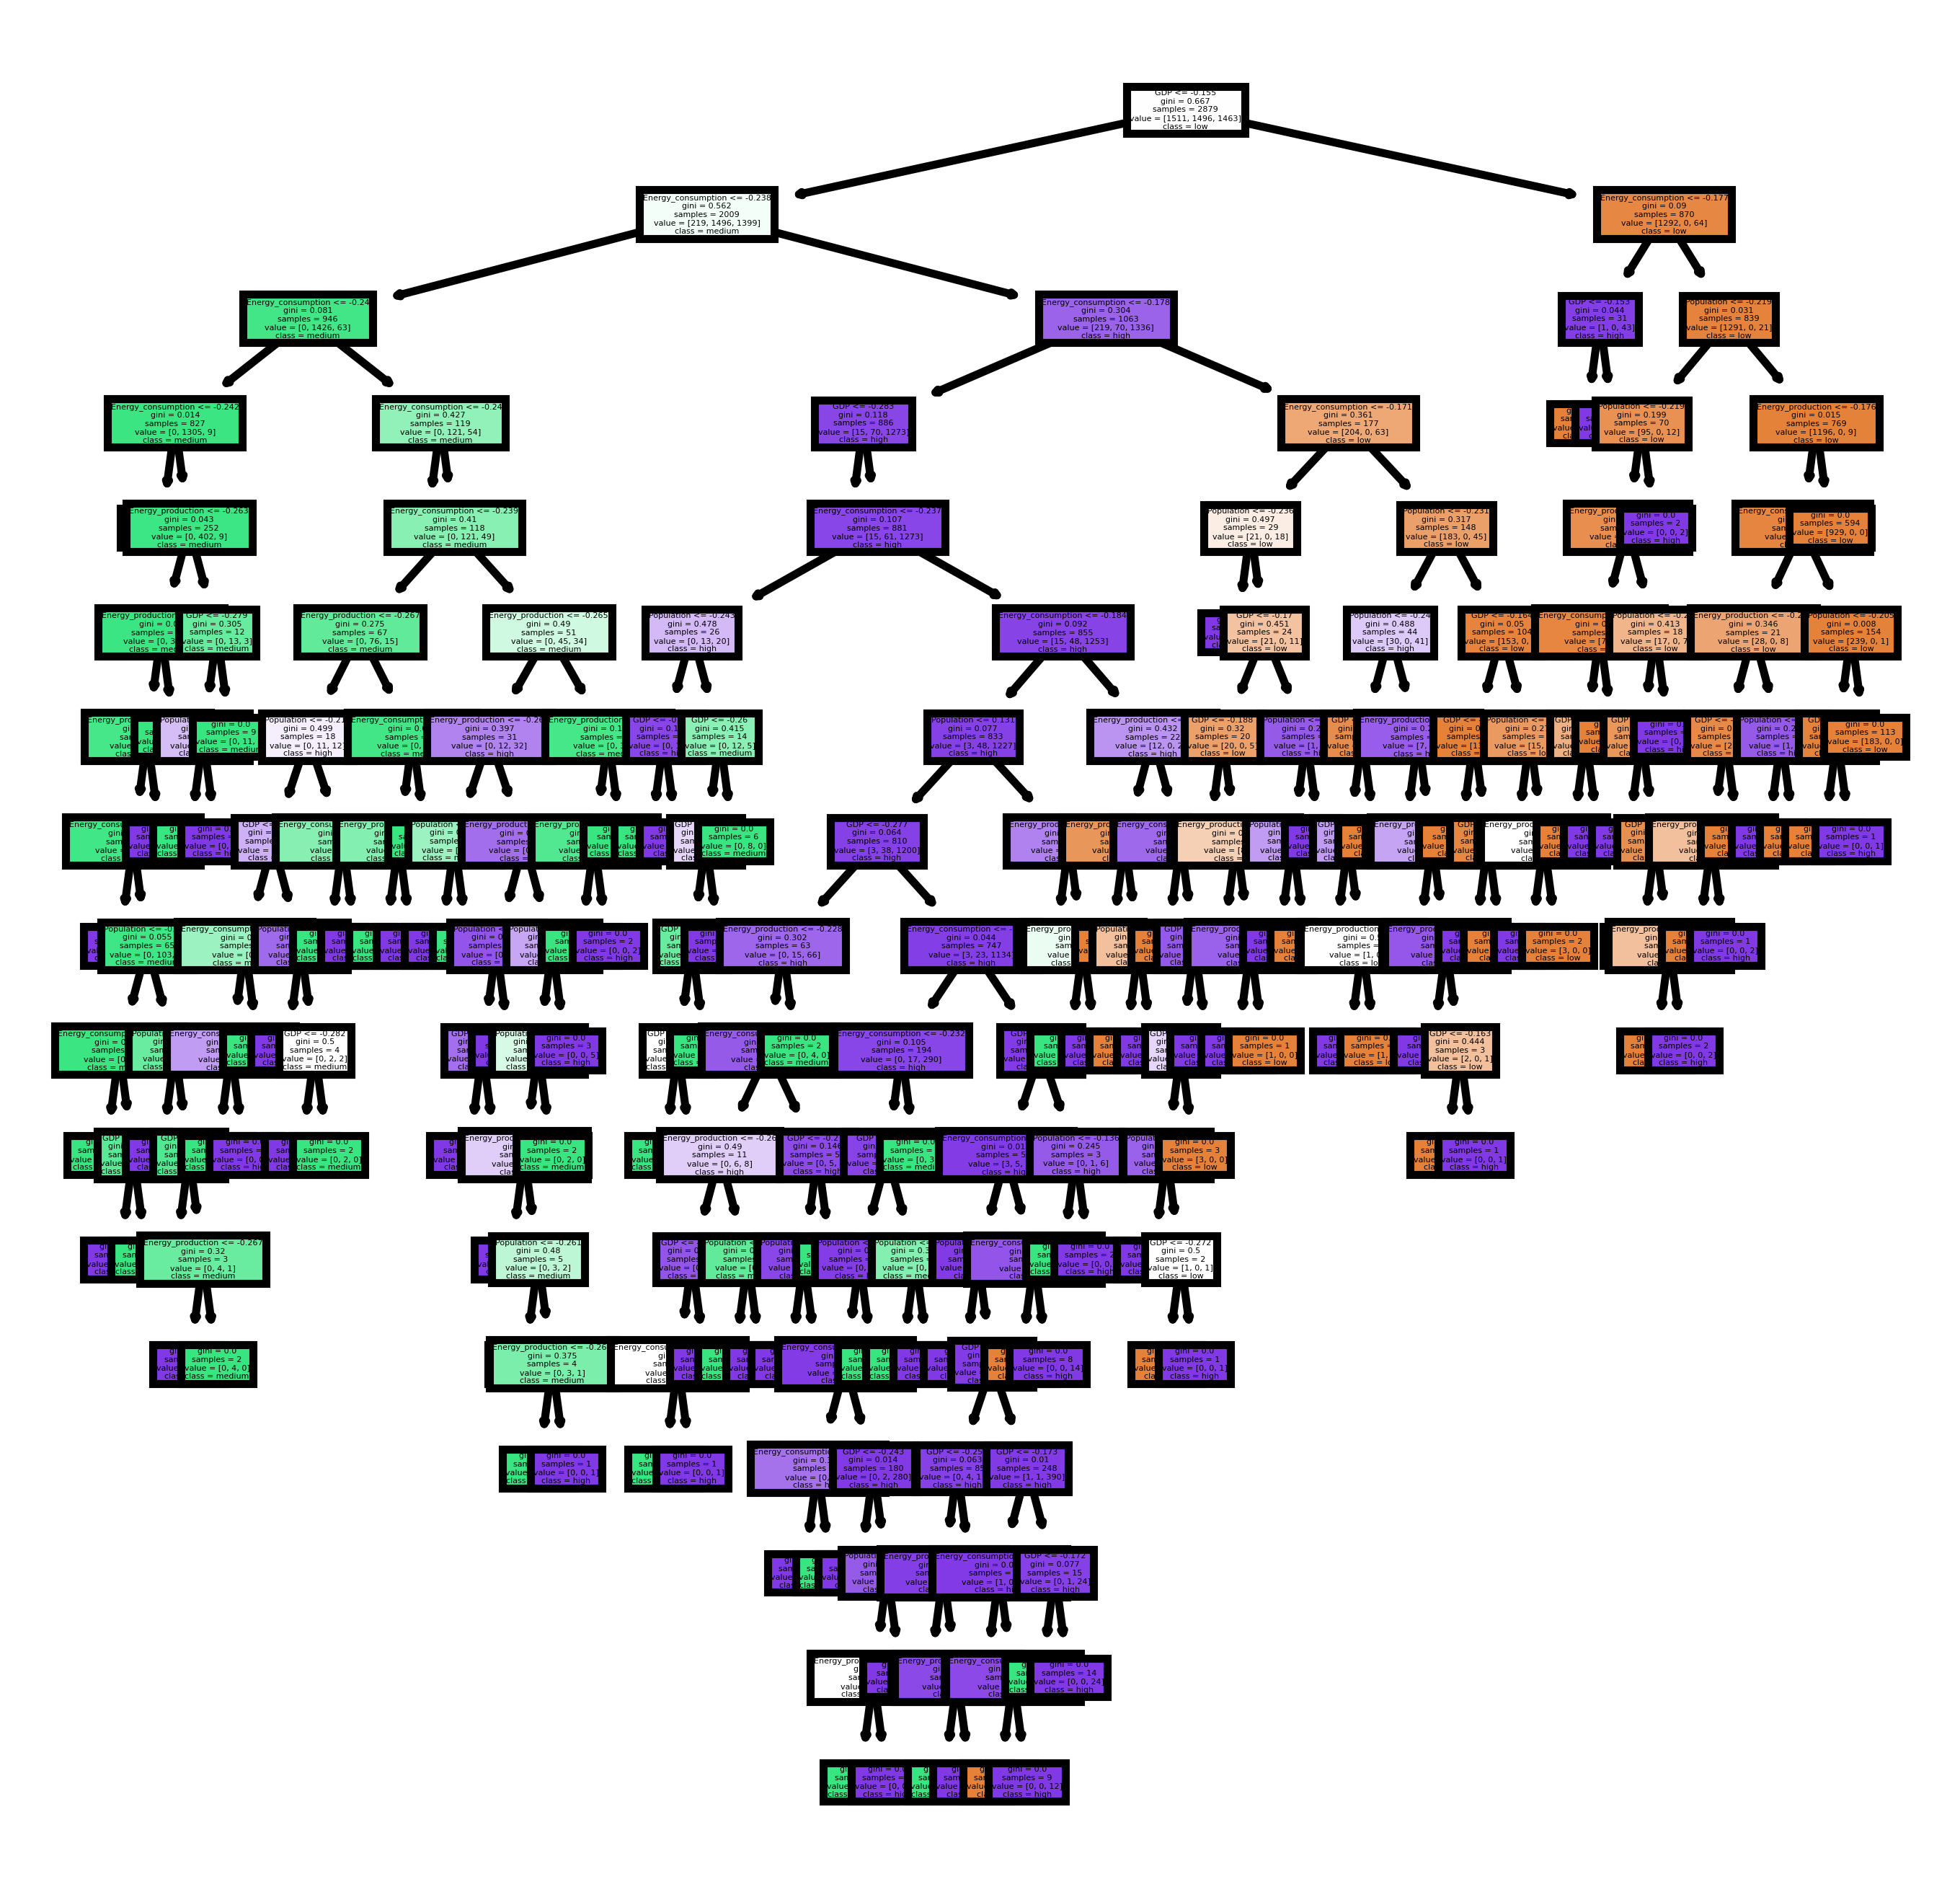

In [17]:
from sklearn import tree

# Select one tree from the forest
chosen_tree = clf.estimators_[5]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(chosen_tree,
               feature_names = names, 
               class_names=['low', 'medium', 'high'],
               filled = True);
fig.savefig('rf_individualtree.png')


## Association Rule Mining using the Apriori algorithm - Relationships between different energy types and the CO2 emission category of "high."

In [18]:
# Load Data
data = df.copy()

# Filter the dataset to include only the desired energy types
energy_types = ['coal', 'natural_gas', 'petroleum_n_other_liquids', 'renewables_n_other']
filtered_data = data[data['Energy_type'].isin(energy_types)]

# Handle missing values in the 'CO2_emission' column (by filling with zeros)
filtered_data['CO2_emission'].fillna(0, inplace=True)

# Discretize the CO2_emission column into categorical bins (low, medium, high)
filtered_data['CO2_emission'] = pd.cut(filtered_data['CO2_emission'], bins=[-1, 0.5, 1.0, float('inf')], labels=['low', 'medium', 'high'])

# Convert the 'Category' object to a string
filtered_data['CO2_emission'] = filtered_data['CO2_emission'].astype(str)

# Create a new dataset containing only the categorical variables
categorical_data = filtered_data[['Country', 'Energy_type', 'CO2_emission']]

# Transform the dataset into a list of transactions
transactions = []
for _, row in categorical_data.iterrows():
    transaction = [f"{col}={row[col]}" for col in categorical_data.columns]
    transactions.append(transaction)

# Encode the transactions in a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
one_hot_encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(one_hot_encoded_data, min_support=0.01, use_colnames=True)

# Generate the association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filter the rules based on the desired relationships (e.g., high CO2 emissions)
rules = rules[rules['consequents'].apply(lambda x: 'CO2_emission=high' in x)].sort_values(['confidence', 'lift'], ascending=False)

# Print the filtered rules
print(rules)


C:\Users\sisma\AppData\Local\Temp\ipykernel_23960\2757398544.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sisma\AppData\Local\Temp\ipykernel_23960\2757398544.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sisma\AppData\Local\Temp\ipykernel_23960\2757398544.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

                               antecedents          consequents  \
2  (Energy_type=petroleum_n_other_liquids)  (CO2_emission=high)   
0                (Energy_type=natural_gas)  (CO2_emission=high)   

   antecedent support  consequent support   support  confidence      lift  \
2            0.248913            0.404808  0.194967    0.783274  1.934925   
0            0.248951            0.404808  0.114689    0.460686  1.138036   

   leverage  conviction  zhangs_metric  
2  0.094205    2.746281       0.643313  
0  0.013911    1.103610       0.161499  


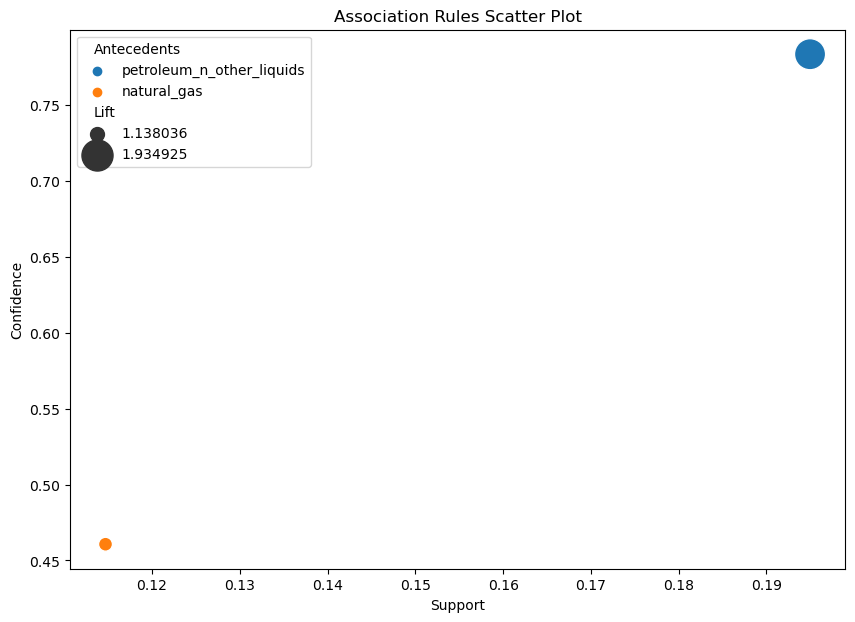

In [19]:
# Create a DataFrame with the association rules
association_rules_df = pd.DataFrame({
    'Antecedents': ['petroleum_n_other_liquids', 'natural_gas'],
    'Consequents': ['CO2_emission=high', 'CO2_emission=high'],
    'Support': [0.194967, 0.114689],
    'Confidence': [0.783274, 0.460686],
    'Lift': [1.934925, 1.138036]
})

# Plot the scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=association_rules_df, x='Support', y='Confidence', size='Lift', hue='Antecedents', sizes=(100, 500), legend='full')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules Scatter Plot')
plt.show()

## Clustering Analysis  - Group Continents based on their total CO2 emissions.

In [20]:
#group data for clustering
df_grouped = df[df['Continent']!='World'].groupby(['Continent', 'Year'])[['Energy_consumption', 'Energy_production', 'GDP', 'Population', 'Energy_intensity_per_capita', 'Energy_intensity_by_GDP', 'CO2_emission']].agg('sum').reset_index()

# Filter the necessary columns
df_co2 = df_grouped[['Continent', 'CO2_emission']]

# Group the data by continent and calculate the total CO2 emission for each continent
df_co2 = df_co2.groupby('Continent').sum().reset_index()

# Fit the KMeans model with k=3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_co2[['CO2_emission']])

# Add the predicted cluster labels to the original dataset
df_co2['cluster'] = kmeans.labels_

# Print the results
print(df_co2)


       Continent   CO2_emission  cluster
0         Africa   64175.658121        0
1           Asia  805395.104311        2
2         Europe  419914.320003        1
3  North America  499172.496429        1
4        Oceania   28606.226151        0
5  South America   57817.032645        0


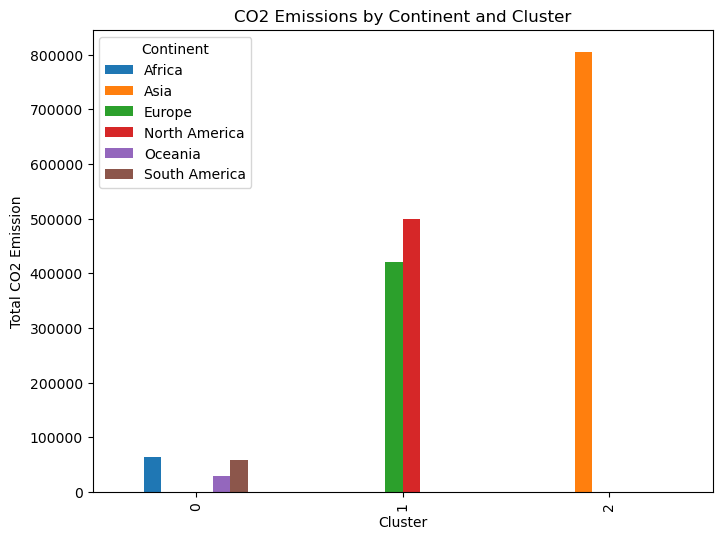

In [21]:
# Create a bar chart of the total CO2 emissions for each continent, grouped by cluster
fig, ax = plt.subplots(figsize=(8,6))
df_co2.groupby(['cluster', 'Continent']).sum()['CO2_emission'].unstack().plot(kind='bar', ax=ax)

# Add labels and title
ax.set_xlabel('Cluster')
ax.set_ylabel('Total CO2 Emission')
ax.set_title('CO2 Emissions by Continent and Cluster')

# Show the plot
plt.show()

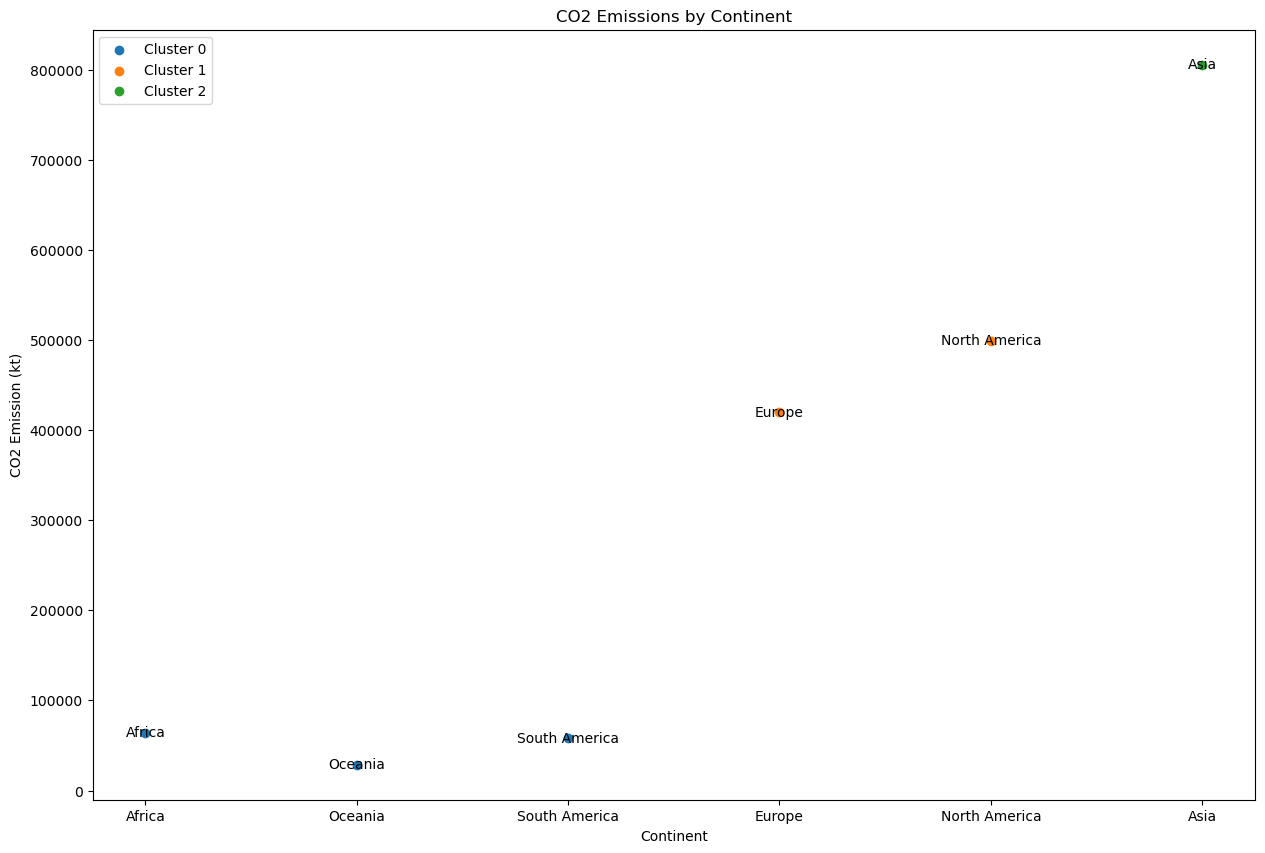

In [22]:
# Filter the necessary columns
df_co2 = df_grouped[['Continent', 'CO2_emission']]

# Group the data by continent and calculate the total CO2 emission for each continent
df_co2 = df_co2.groupby('Continent').sum().reset_index()

# Fit the KMeans model with k=3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_co2[['CO2_emission']])

# Add the predicted cluster labels to the original dataset
df_co2['cluster'] = kmeans.labels_

# Create a scatter plot of CO2 emissions by continent, colored by cluster
fig, ax = plt.subplots(figsize=(15,10))
for cluster, group in df_co2.groupby('cluster'):
    ax.scatter(group['Continent'], group['CO2_emission'], label=f'Cluster {cluster}')
    for x, y, label in zip(group['Continent'], group['CO2_emission'], group['Continent']):
        ax.text(x, y, label, ha='center', va='center')
ax.set_xlabel('Continent')
ax.set_ylabel('CO2 Emission (kt)')
ax.set_title('CO2 Emissions by Continent')
ax.legend()
plt.show()

## Regression Analysis using XGBoost - Predict Country CO2 emissions for 2020 

In [23]:
# Prepare the input and target variables
data = df[(df['Energy_type'] == 'all_energy_types') & (df['Country'] != 'World')].copy()
data= data.groupby('Country').apply(lambda group: group.interpolate(method='linear', limit_direction='both'))

X = data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]
y = data['CO2_emission']

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 500, 1000]
}

# Create the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Print the best parameter combination and corresponding MSE score
print("Best Parameters: ", grid_search.best_params_)
print("Best MSE Score: ", -grid_search.best_score_)

#Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 500
}

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,**params)
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Prepare the data for predicting CO2 emissions for 2020
years_to_predict = [2020]
countries = data['Country'].unique()

predictions = []
for country in countries:
    country_data = data[data['Country'] == country]
    if not country_data.empty:
        prev_year_data = country_data[country_data['Year'] == 2019] # Assuming 2019 is the last year in your dataset
        if not prev_year_data.empty:
            new_data = prev_year_data.copy()
            new_data['Year'] = 2020

            X_pred = new_data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]
            y_pred = model.predict(X_pred)
            predictions.append({'Country': country, 'Year': 2020, 'CO2_emission': y_pred[0]})

# Create a DataFrame with the predictions
prediction_df = pd.DataFrame(predictions)
prediction_df


Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best MSE Score:  62039.89377840542
Mean squared error: 1596.2935388153303


Country  Year  CO2_emission
0            Afghanistan  2020      8.108650
1                Albania  2020      5.256202
2                Algeria  2020    149.530212
3                 Angola  2020     21.258102
4    Antigua and Barbuda  2020      4.462828
..                   ...   ...           ...
190            Venezuela  2020    128.015411
191              Vietnam  2020    210.210098
192                Yemen  2020      9.154722
193               Zambia  2020     12.096532
194             Zimbabwe  2020      9.020797

[195 rows x 3 columns]

In [24]:
data = pd.concat([data, prediction_df], ignore_index=True)
data.to_csv('data_pred_country.csv', index=False)



### Top 11 Countries

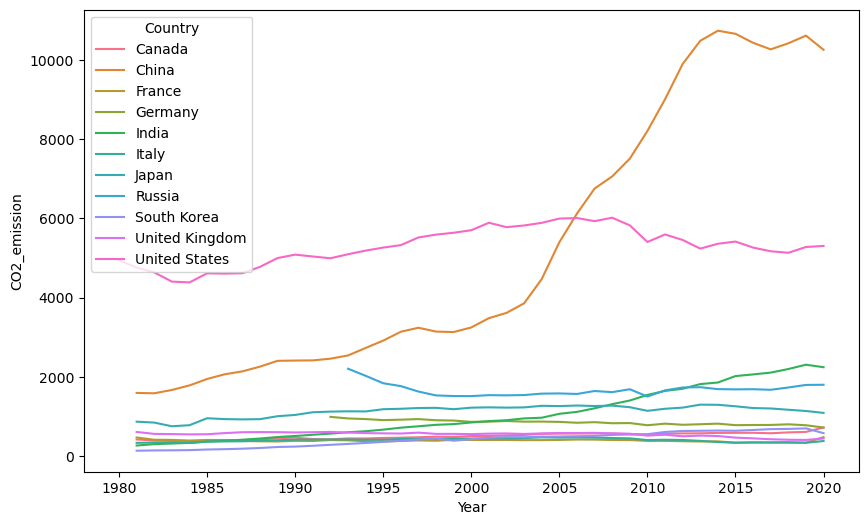

In [25]:
# Get total CO2 emissions per country
total_emissions = data.groupby('Country')['CO2_emission'].sum().sort_values(ascending=False)

# Select the top 11 countries
top_countries = total_emissions.index[:11]

# Filter data for these countries
top_data = data[data['Country'].isin(top_countries)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=top_data, x='Year', y='CO2_emission', hue='Country')
plt.show()



In [26]:
# Line Chart in plotly!

fig = px.line(top_data, x='Year', y='CO2_emission', color='Country', title='CO2 Emissions Over Time')
fig.show()


# Regression Analysis using XGBoost - Predict Continent CO2 emissions for 2020 

In [27]:
# Prepare the input and target variables
data = df[df['Energy_type']=='all_energy_types'].copy()

# Group by continent and year, and sum the other variables
data = data.groupby(['Continent', 'Year'], as_index=False).sum()

X = data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]
y = data['CO2_emission']


# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 500, 1000]
}

# Create the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Print the best parameter combination and corresponding MSE score
print("Best Parameters: ", grid_search.best_params_)
print("Best MSE Score: ", -grid_search.best_score_)


# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
params = {
    'learning_rate': 0.1,
    'max_depth': 9,
    'n_estimators': 500
}

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,**params)
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Prepare the data for predicting CO2 emissions for 2020
years_to_predict = [2020]
continents = data['Continent'].unique()

predictions = []

for continent in continents:
    continent_data = data[data['Continent'] == continent]

    if not continent_data.empty:
        prev_year_data = continent_data[continent_data['Year'] == 2019]
        if not prev_year_data.empty:
            new_data = prev_year_data.copy()
            new_data['Year'] = 2020

            X_pred = new_data[['Energy_consumption', 'Energy_production', 'GDP', 'Population']]
            y_pred = model.predict(X_pred)

            predictions.append({'Continent': continent, 'Year': 2020, 'CO2_emission': y_pred[0]})

# Create a DataFrame with the predictions
prediction_df = pd.DataFrame(predictions)
grouped_df = data.groupby(['Continent', 'Year'])['CO2_emission'].sum().reset_index()
# Merge the predicted data with the original DataFrame
data_pred = pd.concat([grouped_df, prediction_df], axis=0, join='inner')

# Save the DataFrame to a CSV file
data_pred.to_csv('co2_pred_cont.csv', index=False)

pd.set_option('display.max_rows', None)
print(prediction_df)



Best Parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}
Best MSE Score:  11136838.002148954
Mean squared error: 156742.2987018007
       Continent  Year  CO2_emission
0         Africa  2020   1301.644043
1           Asia  2020  19578.007812
2         Europe  2020   6130.002930
3  North America  2020   6517.918945
4        Oceania  2020    528.989502
5  South America  2020   1068.005737
6          World  2020  35584.894531


In [28]:
# Group by 'Year' and 'Continent' and calculate the mean of 'CO2_emission_prediction'
grouped_data = data_pred.groupby(['Year', 'Continent'], as_index=False).mean()

# Now, create the plot
fig = px.line(data_pred, x="Year", y="CO2_emission", color="Continent", 
              title='Predicted CO2 Emissions by Continent', 
              labels={'CO2_emission_prediction': 'CO2 Emission Predictions'})

fig.show()


## Time Series Forecasting using Arima - Continent CO2 emissions for 2020 - 2023

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


# Load Data
data = df[(df['Energy_type'] == 'all_energy_types') & (df['Continent'] != 'World')].copy()
predictions = []
# Aggregate data by continent and year
data = data.groupby(['Continent', 'Year'])['CO2_emission'].sum().reset_index()

# Get the unique continents in the dataset
continents = data['Continent'].unique()

# Loop through each continent and fit an ARIMA model for CO2 emissions
for continent in continents:
    continent_data = data[data['Continent'] == continent].sort_values('Year')
    co2_by_year = continent_data[['Year', 'CO2_emission']].set_index('Year')
    
    try:
        # Fit the ARIMA model
        model = ARIMA(co2_by_year, order=(1, 1, 0))
        model_fit = model.fit()

        # Make predictions for the next 4 years (2020, 2021, 2022, and 2023)
        forecast = model_fit.forecast(steps=4)

        # Append the predictions for each year to the list
        for year, prediction in zip([2020, 2021, 2022, 2023], forecast):
            predictions.append({'Continent': continent, 'Year': year, 'CO2_emission_prediction': prediction})
    except:
        print(f"Unable to fit ARIMA model for {continent}")

# Create a DataFrame with the predictions
predicted_data = pd.DataFrame(predictions)
print(predicted_data)



        Continent  Year  CO2_emission_prediction
0          Africa  2020              1302.459889
1          Africa  2021              1302.646533
2          Africa  2022              1302.687342
3          Africa  2023              1302.696265
4            Asia  2020             20390.438248
5            Asia  2021             20703.090930
6            Asia  2022             20966.322595
7            Asia  2023             21187.945225
8          Europe  2020              6133.112160
9          Europe  2021              6133.663233
10         Europe  2022              6133.761492
11         Europe  2023              6133.779012
12  North America  2020              6545.412607
13  North America  2021              6550.449099
14  North America  2022              6551.371472
15  North America  2023              6551.540394
16        Oceania  2020               455.038156
17        Oceania  2021               453.501763
18        Oceania  2022               452.893996
19        Oceania  2

C:\Users\sisma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\sisma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\sisma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\sisma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\sisma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: DeprecationWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\sisma\anaconda

In [30]:
import plotly.graph_objects as go

# Concatenate the original and predicted data
data['CO2_emission_prediction'] = np.nan
merged_data = pd.concat([data, predicted_data], ignore_index=True)

# Get the unique continents
continents = merged_data['Continent'].unique()

# Initialize a plotly graph object
fig = go.Figure()

# For each continent, add a trace to the figure
for continent in continents:
    continent_data = merged_data[merged_data['Continent'] == continent]

    # Add a trace for the original data
    fig.add_trace(go.Scatter(
        x=continent_data['Year'], 
        y=continent_data['CO2_emission'],
        mode='lines',
        name=f'{continent} - Original'
    ))

    # Add a trace for the predicted data
    fig.add_trace(go.Scatter(
        x=continent_data['Year'], 
        y=continent_data['CO2_emission_prediction'],
        mode='lines',
        line=dict(dash='dash'),
        name=f'{continent} - Predicted'
    ))

# Set the layout of the figure
fig.update_layout(
    title='CO2 Emissions by Continent',
    xaxis_title='Year',
    yaxis_title='CO2 Emissions',
    hovermode='x'
)

# Show the figure
fig.show()
